In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import json

In [2]:
data_root = "ssl_dataset"
train_dirs = ["train.X1", "train.X2", "train.X3", "train.X4"]
val_dir = "val.X"
label_map_file="Labels.json"
batch_size = 786
image_size = 60
epochs = 4
mask_ratio = 0.75
learning_rate = 7e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class MAEDataset(Dataset):
    def __init__(self, root_dirs, transform):
        self.samples = []
        for rd in root_dirs:
            folder = os.path.join(data_root, rd)
            for class_folder in os.listdir(folder):
                class_path = os.path.join(folder, class_folder)
                for fname in os.listdir(class_path):
                    self.samples.append(os.path.join(class_path, fname))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img


In [4]:
class ImageNetVal(Dataset):
    def __init__(self, root, transform):
        self.samples = []
        self.labels = []
        with open(os.path.join(data_root,label_map_file)) as f:
                original_dict=json.load(f)
        class_names = list(original_dict.keys())
        label_to_index = {name: idx for idx, name in enumerate(class_names)}
        for class_folder in os.listdir(root):
            class_path = os.path.join(root, class_folder)
            label = label_to_index[class_folder] 
            for fname in os.listdir(class_path):
                self.samples.append(os.path.join(class_path, fname))
                self.labels.append(label)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('RGB')
        return self.transform(img), self.labels[idx]


In [5]:
def random_masking(x, ratio):
    B, C, H, W = x.size()
    L = H * W
    num_mask = int(L * ratio)
    mask = torch.ones(L, dtype=torch.bool)
    perm = torch.randperm(L)[:num_mask]
    mask[perm] = False
    mask = mask.reshape(H, W).unsqueeze(0).repeat(B, 1, 1).to(device)
    return x * mask.unsqueeze(1), mask

In [6]:
class MAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.resnet18(pretrained=False)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),     
            nn.Upsample(size=(60,60), mode='bilinear', align_corners=False)
   
        )
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [7]:
def train_mae():
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    dataset = MAEDataset(train_dirs, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    model = MAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    loss_curve = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i,imgs in enumerate(loader):
            imgs = imgs.to(device)
            masked_imgs, _ = random_masking(imgs, mask_ratio)
            recons = model(masked_imgs)
            loss = loss_fn(recons, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f"Finished batch {i+1}/{len(loader)}") if (i+1)%100==0 else None

        avg_loss = total_loss / len(loader)
        loss_curve.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss:.4f}")

    torch.save(model.encoder.state_dict(), "mae_encoder.pth")

In [ ]:
def probe_mae():
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    val_dataset = ImageNetVal(os.path.join(data_root, val_dir), transform)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder = models.resnet18(pretrained=False)
    encoder = nn.Sequential(*list(encoder.children())[:-2])
    encoder.load_state_dict(torch.load("mae_encoder.pth"))
    encoder.to(device)
    encoder.eval()
    for param in encoder.parameters():
        param.requires_grad = False

    features, labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            h = encoder(x)
            h = F.adaptive_avg_pool2d(h, (1, 1)).view(h.size(0), -1)
            features.append(h.cpu())
            labels.extend(y)

    features = torch.cat(features)
    labels = torch.tensor(labels)

    classifier = nn.Sequential(
        nn.Linear(features.shape[1], 512),
        nn.ReLU(),
        nn.Linear(512,100)
    )
    classifier.to(device)

    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    acc_list, loss_list, f1_list = [], [], []

    for epoch in range(10000):
        classifier.train()

        perm = torch.randperm(len(features))
        features = features[perm]
        labels = labels[perm]

        total_loss, correct = 0, 0
        preds_all, labels_all = [], []

        for i in range(0, len(features), 64):
            x_batch = features[i:i+64].to(device)
            y_batch = labels[i:i+64].to(device)

            x_batch = F.normalize(x_batch, dim=1)

            preds = classifier(x_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=5)

            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)
            correct += (preds.argmax(1) == y_batch).sum().item()
            preds_all.extend(preds.argmax(1).cpu().tolist())
            labels_all.extend(y_batch.cpu().tolist())

        acc = correct / len(features)
        f1 = f1_score(labels_all, preds_all, average='macro')
        avg_loss = total_loss / len(features)

        acc_list.append(acc)
        loss_list.append(avg_loss)
        f1_list.append(f1)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={acc:.4f}, F1={f1:.4f}")

    plt.figure()
    plt.plot(acc_list, label='Accuracy')
    plt.title('MAE Linear Probe Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("mae_linear_probe_accuracy.png")
    plt.show()

    plt.figure()
    plt.plot(loss_list, label='Loss')
    plt.title('MAE Linear Probe Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("mae_linear_probe_loss.png")
    plt.show()


In [ ]:
#DO NOT RUN AGAIN IF USING WEIGHTS FILE
train_mae()

Finished batch 100/166
Epoch 1/4 Loss: 20.0802
Finished batch 100/166
Epoch 2/4 Loss: 0.0335
Finished batch 100/166
Epoch 3/4 Loss: 0.0306
Finished batch 100/166
Epoch 4/4 Loss: 0.0289


C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 100: Loss=4.0895, Accuracy=0.0714, F1=0.0543
Epoch 200: Loss=3.8251, Accuracy=0.1038, F1=0.0934
Epoch 300: Loss=3.6118, Accuracy=0.1410, F1=0.1332
Epoch 400: Loss=3.4270, Accuracy=0.1682, F1=0.1611
Epoch 500: Loss=3.2712, Accuracy=0.2008, F1=0.1968
Epoch 600: Loss=3.1273, Accuracy=0.2360, F1=0.2318
Epoch 700: Loss=2.9928, Accuracy=0.2638, F1=0.2627
Epoch 800: Loss=2.8807, Accuracy=0.2900, F1=0.2876
Epoch 900: Loss=2.7794, Accuracy=0.3112, F1=0.3101
Epoch 1000: Loss=2.6748, Accuracy=0.3388, F1=0.3388
Epoch 1100: Loss=2.5937, Accuracy=0.3616, F1=0.3613
Epoch 1200: Loss=2.5088, Accuracy=0.3776, F1=0.3772
Epoch 1300: Loss=2.4336, Accuracy=0.3992, F1=0.3988
Epoch 1400: Loss=2.3660, Accuracy=0.4134, F1=0.4140
Epoch 1500: Loss=2.3008, Accuracy=0.4328, F1=0.4341
Epoch 1600: Loss=2.2370, Accuracy=0.4468, F1=0.4475
Epoch 1700: Loss=2.1806, Accuracy=0.4656, F1=0.4675
Epoch 1800: Loss=2.1164, Accuracy=0.4868, F1=0.4893
Epoch 1900: Loss=2.0649, Accuracy=0.4998, F1=0.5011
Epoch 2000: Loss=2.01

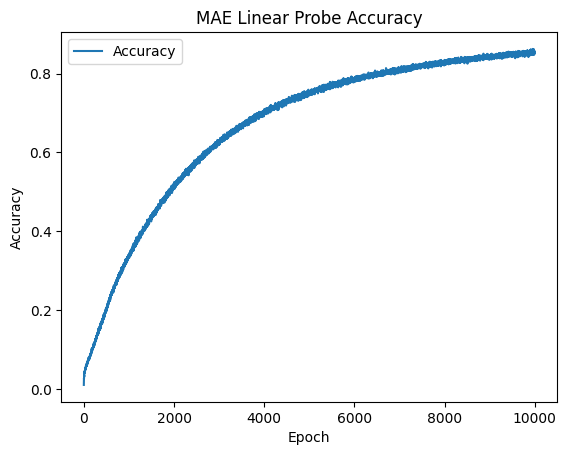

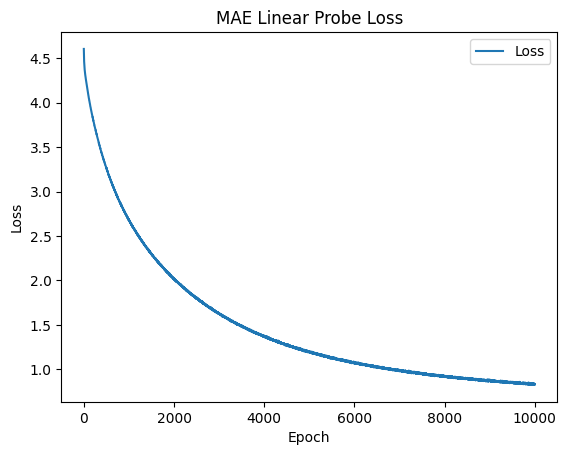

In [ ]:
probe_mae()